In [1]:
#импортируем разное
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import matplotlib.pyplot as plt

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#загрузим модели
RPN_network = tf.keras.models.load_model('RPN.h5')
backbone_encoder = tf.keras.models.load_model('base_classifier.h5')
classifier_network = tf.keras.models.load_model('classifier.h5')

In [3]:
#словарь классов
import json
path_to_json = "C:/users/user/ai tests/autoencoder tests/datasets/annotations/instances_train2014.json"
with open(path_to_json, 'r') as f:
    json_data = json.load(f)
categories_json = json_data['categories']
categories = {}
for c in categories_json:
    categories.update({c['id']: c['name']})
categories.update({0: "object"})

In [40]:
colors = tf.concat([[[1,1,1]],tf.random.uniform([90, 3], 0, 1, dtype = tf.float32)], axis = 0) + 0.5

def draw_box(image, box, color = (255, 0, 0), image_size = 244):
    image = cv2.rectangle(image, 
                          (int(tf.clip_by_value(box[0], 0, image_size)), int(tf.clip_by_value(box[1], 0, image_size))), 
                          (int(tf.clip_by_value(box[2], 0, image_size)), int(tf.clip_by_value(box[3], 0, image_size))),
                          color, 1)
    return image

def draw_boxes(image, boxes, classes, probs, ignore_zero_class = False, image_size = 244):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    for i in range(boxes.shape[0]):
        r = float(colors[classes[i]].numpy()[0])
        g = float(colors[classes[i]].numpy()[1])
        b = float(colors[classes[i]].numpy()[2])
        if classes[i] > 0 or not ignore_zero_class:
            image = draw_box(image, boxes[i], color = (r, g, b), image_size = image_size)
            org = ((int(boxes[i][0]),  int(boxes[i][1])-10))
            text = categories[int(classes[i])] + " " + str(float(probs[i]*100))[:4]
            big_image = cv2.putText(image, text, org, font, fontScale, (r, g, b), thickness, cv2.LINE_AA)
    return image

@tf.function
def IoU(boxA, boxB):
    boxes = tf.concat([tf.expand_dims(boxA, axis = 0), tf.expand_dims(boxB, axis = 0)], axis = 0)
    A = tf.reduce_max(boxes, axis = 0)
    B = tf.reduce_min(boxes, axis = 0)
    xA = A[:, 0]
    yA = A[:, 1]
    xB = B[:, 2]
    yB = B[:, 3]

    interW = tf.nn.relu(xB - xA + 1)
    interH = tf.nn.relu(yB - yA + 1)

    interArea = interW * interH
    boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
    boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)

    iou = interArea / tf.cast(boxAArea + boxBArea - interArea, dtype=tf.float32)
    return iou

@tf.function
def create_position_tensor(n):
    x_positions = tf.linspace(0.0, float(n - 1), n)
    y_positions = tf.linspace(0.0, float(n - 1), n)
    x_grid, y_grid = tf.meshgrid(x_positions, y_positions)
    position_tensor = tf.stack([x_grid, y_grid, x_grid, y_grid], axis=-1)
    return position_tensor

def non_maximum_supression(boxes, scores, th = 0.2):
    num_boxes = boxes.shape[0]
    axis_A = tf.repeat(tf.expand_dims(boxes, axis = 0), num_boxes, axis = 0)
    axis_B = tf.tile(tf.expand_dims(boxes, axis=1), multiples=[1, num_boxes, 1])
    axis_A = tf.reshape(axis_A, [-1, 4])
    axis_B = tf.reshape(axis_B, [-1, 4])
    cross_iou = IoU(axis_A, axis_B)
    resulted_boxes = []
    resulted_scores = []
    #выгрузка с видеокарты для циклического опроса
    cross_iou = cross_iou.numpy()
    scores = scores.numpy()
    for i in range(num_boxes):
        discard = False
        for j in range(num_boxes):
            if (cross_iou[i * num_boxes + j] > th):
                if(scores[j, 1] > scores[i, 1]):
                    discard = True
                    break
        if not discard:
            resulted_boxes.append(boxes[i])
            resulted_scores.append(scores[i])
    resulted_boxes = tf.cast(resulted_boxes, dtype = tf.float32)
    resulted_scores = tf.cast(resulted_scores, dtype = tf.float32)
    return (resulted_boxes, resulted_scores)


def postprocess_proposals(raw_boxes, raw_scores, th = 0.5):
    delta = 17
    shift = create_position_tensor(14)
    raw_boxes += shift
    raw_boxes *= delta
    raw_boxes = tf.clip_by_value(raw_boxes, 0, 244)
    raw_boxes = tf.reshape(raw_boxes, [-1, 4])
    raw_scores = tf.reshape(raw_scores, [-1, 2])
    boxes, scores = non_maximum_supression(raw_boxes, raw_scores)
    top_boxes = []
    top_scores = []
    for i in range(boxes.shape[0]):
        if scores[i, 1] > th:
            top_boxes.append(boxes[i])
            top_scores.append(scores[i, 1])
    top_boxes = tf.stack(top_boxes)
    top_scores = tf.stack(top_scores)
    return (top_boxes, top_scores)

def fill(shape, value):
    for ax in shape:
        value = tf.repeat(tf.expand_dims(value, axis = 1), ax, axis = 1)
    return value 

def roi_pool(boxes, feature_map, embedding_size = 3, image_size = 224):
    feature_map_size = feature_map.shape[0] - 1
    num_filters = feature_map.shape[2]
    num_boxes = boxes.shape[0]
    scale = feature_map_size / image_size
    scaled_boxes = boxes*scale
    box_width = scaled_boxes[:, 2] - scaled_boxes[:, 0]
    box_height = scaled_boxes[:, 3] - scaled_boxes[:, 1]

    x_positions = tf.linspace(0.0, float(embedding_size - 1), embedding_size)
    y_positions = tf.linspace(0.0, float(embedding_size - 1), embedding_size)
    x_grid, y_grid = tf.meshgrid(x_positions, y_positions)
    grid_shape = x_grid.shape
    x_grid = tf.repeat(tf.expand_dims(x_grid, axis = 0), num_boxes, axis = 0)
    y_grid = tf.repeat(tf.expand_dims(y_grid, axis = 0), num_boxes, axis = 0)

    position_tensor = tf.stack([fill(grid_shape, scaled_boxes[:, 0]) + x_grid * fill(grid_shape, box_width / embedding_size),
                                fill(grid_shape, scaled_boxes[:, 1]) + y_grid * fill(grid_shape, box_height / embedding_size),
                                fill(grid_shape, scaled_boxes[:, 0]) + (x_grid + 1) * fill(grid_shape, box_width / embedding_size),
                                fill(grid_shape, scaled_boxes[:, 1]) + (y_grid + 1) * fill(grid_shape, box_height / embedding_size)], axis=-1)
    cuts = tf.cast(position_tensor, dtype = tf.int32)


    shifts = tf.stack([tf.zeros(cuts.shape[:-1], dtype = tf.int32),
                       tf.zeros(cuts.shape[:-1], dtype = tf.int32),
                       tf.ones(cuts.shape[:-1], dtype = tf.int32),
                       tf.ones(cuts.shape[:-1], dtype = tf.int32)], axis = -1)
    cuts += shifts
    result = []
    for batch in range(num_boxes):
        temp1 = []
        for i in range(embedding_size):
            temp2 = []
            for j in range(embedding_size):
                a = tf.reduce_max(feature_map[cuts[batch, j, i, 0]:cuts[batch, j, i, 2], cuts[batch, j, i, 1]:cuts[batch, j, i, 3],: ], axis = (0, 1))
                temp2.append(a)
            temp1.append(tf.stack(temp2))
        result.append(tf.stack(temp1))
    result = tf.stack(result)

    return result

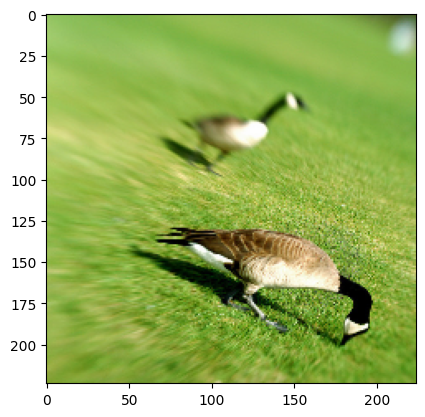

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


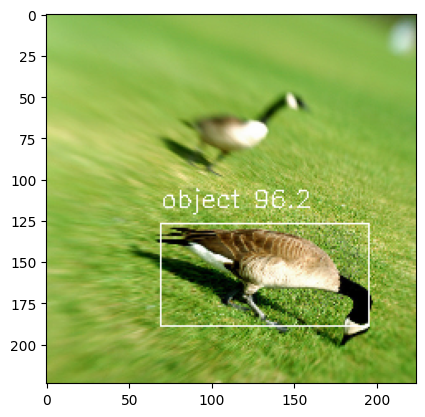

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


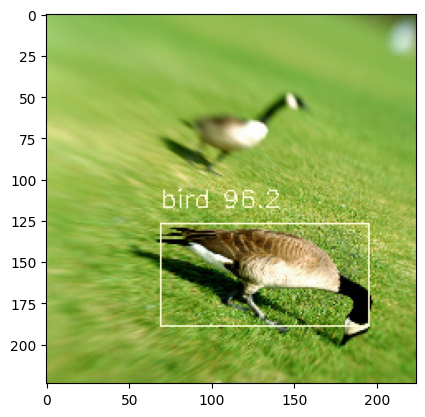

In [42]:
#inference для одного изображения
path = "C:/users/user/ai tests/autoencoder tests/datasets/train2014/COCO_train2014_000000009640.jpg"
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
image = tf.cast(image, dtype = tf.float32) / 128 - 1
image = tf.image.resize(image, (224, 224))
test_image = ((image+1)/2).numpy()
plt.imshow(test_image)
plt.show()

raw_scores, raw_boxes = RPN_network(tf.expand_dims(image, axis = 0))
boxes, scores = postprocess_proposals(raw_boxes, raw_scores)
classes = tf.zeros([boxes.shape[0]], dtype = tf.int32)
test_image = draw_boxes(test_image, boxes, classes, scores)
plt.imshow(test_image)
plt.show()

feature_map = backbone_encoder(tf.expand_dims(image, axis = 0))
rois = roi_pool(boxes, feature_map[0])
probs = classifier_network(rois)
classes = tf.argmax(probs, axis = 1)
test_image = ((image+1)/2).numpy()
test_image = draw_boxes(test_image, boxes, classes, scores)
plt.imshow(test_image)
plt.show()

In [43]:
def detect(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image = tf.cast(image, dtype = tf.float32) / 128 - 1
    big_image = tf.image.resize(image, (224*5, 224*5))
    image = tf.image.resize(image, (224, 224))
    raw_scores, raw_boxes = RPN_network(tf.expand_dims(image, axis = 0))
    boxes, scores = postprocess_proposals(raw_boxes, raw_scores, th = 0.8)
    if (len(boxes.shape)> 1):
        feature_map = backbone_encoder(tf.expand_dims(image, axis = 0))
        rois = roi_pool(boxes, feature_map[0])
        probs = classifier_network(rois)
        classes = tf.argmax(probs, axis = 1)
        big_image = ((big_image+1)/2).numpy()
        big_image = draw_boxes(big_image, boxes*5, classes, scores, ignore_zero_class = True, image_size = 224 * 5)  
    else:   
        big_image = ((big_image+1)/2).numpy() 
    big_image = big_image*255
    big_image = tf.cast(big_image, dtype = tf.uint8)
    big_image = big_image.numpy()
    big_image = cv2.cvtColor(big_image, cv2.COLOR_BGR2RGB) 
    return big_image

In [29]:
#inference для видео
cap = cv2.VideoCapture('test video.mp4')
 

if (cap.isOpened()== False): 
    print("Error opening video stream or file")
    
frame_width = 224*5
frame_height = 224*5
   
size = (frame_width, frame_height)
print(size)

result = cv2.VideoWriter('filename.avi', cv2.VideoWriter_fourcc(*'MJPG'),10, size)
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame = detect(frame)
        cv2.imshow('Frame', frame)
        result.write(frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else: 
        break
result.release()
cap.release()
cv2.destroyAllWindows()

(1120, 1120)
